# Plan et Définition des fonctions

In [1]:
from IPython.display import display, HTML
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import itertools

plt.style.use('ggplot')

from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
#from imblearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE,RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score, make_scorer, f1_score

from sklearn.model_selection import StratifiedShuffleSplit,train_test_split, cross_val_predict, GridSearchCV, RandomizedSearchCV, cross_val_score, learning_curve, ShuffleSplit, validation_curve
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble.gradient_boosting import GradientBoostingRegressor,GradientBoostingClassifier

from sklearn.svm import SVR, SVC
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, LassoLarsCV, ElasticNet, ElasticNetCV, LogisticRegressionCV, LogisticRegression, SGDClassifier
import sklearn.metrics as sk_metrics

import mord

In [2]:
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2))

In [1]:
def plot_confusion_matrix(estimator, X, y,title='',class_names=None, figsize = (10,7), fontsize=14):
    pred_class=estimator.predict(X)
    confusion_mat= confusion_matrix(y, pred_class)
    if class_names is None:
        class_names=range(confusion_mat.shape[0])
    df_cm = pd.DataFrame(confusion_mat, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    plt.title(title)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [4]:
def get_quality_scores(model,model_name, X_train, X_test, y_train, y_test):
    """ save scoring of the model into a dataframe
    """
    res         = pd.DataFrame(np.zeros((8,1)))
    res.columns = [model_name]
    res.index   = ['Train Accuracy', 'Train Average Recall', 'Train Average Precision', 'Train Average F1 Score', 'Test Accuracy','Test Average Recall', 'Test Average Precision', 'Test Average F1 Score']
    #train
    res.iloc[0,0] = '{:.2%}'.format(sk_metrics.accuracy_score(y_train, model.predict(X_train)))
    res.iloc[1,0] = '{:.2%}'.format(sk_metrics.balanced_accuracy_score(y_train, model.predict(X_train)))
    res.iloc[2,0] = '{:.2%}'.format(sk_metrics.precision_score(y_train, model.predict(X_train), average='macro'))
    res.iloc[3,0] = '{:.2%}'.format(sk_metrics.f1_score(y_train, model.predict(X_train), average='macro'))
    #test                                
    res.iloc[4,0] = '{:.2%}'.format(sk_metrics.accuracy_score(y_test, model.predict(X_test)))
    res.iloc[5,0] = '{:.2%}'.format(sk_metrics.balanced_accuracy_score(y_test, model.predict(X_test)))
    res.iloc[6,0] = '{:.2%}'.format(sk_metrics.precision_score(y_test, model.predict(X_test), average='macro'))
    res.iloc[7,0] = '{:.2%}'.format(sk_metrics.f1_score(y_test, model.predict(X_test), average='macro'))
    return(res)

In [5]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.2, 1.0, 5), scorer=None):
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    ax.set_title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    skf = StratifiedKFold(n_splits=5)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=skf, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scorer)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    ax.legend(loc="best")
    return fig,ax

In [6]:
def plot_validation_curve(estimator, X, y, param_name, params, title='', scorer=None):
    skf = StratifiedKFold(n_splits=5)
    train_scores, valid_scores = validation_curve(estimator, X, y, param_name, params, cv=skf,scoring=scorer)
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    ax.set_title(title)
    ax.plot(params, train_scores.mean(axis=1), 'o-', color='r', label='Training Scores')
    ax.fill_between(params, train_scores.mean(axis=1)-train_scores.std(axis=1), train_scores.mean(axis=1)+train_scores.std(axis=1),color='r', alpha=0.1)
    ax.plot(params, valid_scores.mean(axis=1), 'o-', color='g', label='Validation scores')
    ax.fill_between(params, valid_scores.mean(axis=1)-valid_scores.std(axis=1), valid_scores.mean(axis=1)+valid_scores.std(axis=1), color='g', alpha=0.1)
    ax.legend(loc='best')
    ax.set_xscale('log')
    return fig, ax

In [7]:
def calibrate_hyperparameters_RandomizedSearch(estimator, grid, X_train, y_train):
    rf_random = RandomizedSearchCV(estimator = estimator, param_distributions = grid, n_iter = 300, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    rf_random.fit(X_train, y_train)
    return(rf_random.best_estimator_, rf_random.best_params_)

In [8]:
ordered_rating=pd.read_csv('data/rating_encode.csv', index_col=1).rating

In [9]:
def convert_column(s):
    try:
        return(float(s))
    except ValueError:
        if s.endswith('T'):
            return(float(s[:-1])*1e12)
        elif s.endswith('B'):
            return(float(s[:-1])*1e9)
        elif s.endswith('M'):
            return(float(s[:-1])*1e6)
        elif s.endswith('k'):
            return(float(s[:-1])*1e3)
        elif s.endswith('%'):
            try:
                return(float(s[:-1])*1e-2)
            except ValueError:
                return(np.nan)
        elif s=='--':
            return(np.nan)
        else:
            return(s)
convert_column=np.vectorize(convert_column)

In [10]:
def import_data():
    correspondance = pd.read_csv('data/codes.csv')
    df1 = pd.read_csv('data/extract1.csv', index_col=0)
    df1.dropna(subset=['Short Name'],inplace=True)
    df1.columns=correspondance.code.iloc[1:41]

    df2 = pd.read_csv('data/extract2.csv',index_col=0)
    df2.dropna(subset=['Short Name'], inplace=True)
    df2 = df2.iloc[:,1:]
    df2.columns = correspondance.code.iloc[41:78]

    df3 = pd.read_csv('data/extract3.csv', index_col=0)
    df3.dropna(subset=['Short Name'],inplace=True)
    df3 = df3.iloc[:,1:]
    df3.columns = correspondance.code.iloc[78:88]

    df4 = pd.read_csv('data/extract4.csv',index_col=0)
    df4.dropna(subset=['Short Name'],inplace=True)
    df4 = df4.iloc[:,1:]
    df4.columns=correspondance.code.iloc[88:]

    df=df1
    df=df.combine_first(df2)
    df=df.combine_first(df3)
    df=df.combine_first(df4)

    mask=(correspondance.type=='Numeric')
    numeric_columns=correspondance[mask].code
    #convert format
    df[numeric_columns]=df[numeric_columns].apply(convert_column)

    #format Rating
    df.RATING[df.RATING=='NR']=np.nan
    df=df[df.RATING.notna()] #remove non rated companies as they do not help in learning
    return(df)

df=import_data()

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# I - Importing of DATA

In [11]:
table_rating = pd.read_csv('data/rating_encode.csv', index_col=0)

def f_encode_rating(rating):
    if pd.isnull(rating):
        return(np.nan)
    else:
        return(table_rating.loc[rating].code)

def f_decode_rating(number):
    number= min(max(number,0), 17)
    if pd.isnull(number):
        return(np.nan)
    else:
        return(table_rating[table_rating.code==int(np.round(number))].index[0])

df['ENCODED_RATING']=df.RATING.apply(f_encode_rating)

table_rating.code

rating
AAA      17
AA+      16
AA       15
AA-      14
A+       13
A        12
A-       11
BBB+     10
BBB       9
BBB-      8
BB+       7
BB        6
BB-       5
B+        4
B         3
B-        2
CCC/C     1
Name: code, dtype: int64

In [12]:
class_names=list(table_rating.sort_values(by='code').index)
class_names

['CCC/C',
 'B-',
 'B',
 'B+',
 'BB-',
 'BB',
 'BB+',
 'BBB-',
 'BBB',
 'BBB+',
 'A-',
 'A',
 'A+',
 'AA-',
 'AA',
 'AA+',
 'AAA']

In [13]:
df['CASH_TO_LT_DEBT']  = df.BS_LT_BORROW/df.CF_FREE_CASH_FLOW
df['RETURN_ON_CAP']    = df.NET_OPER_PROFIT_AFTER_TAX/df.TOTAL_INVESTED_CAPITAL
df['CF_FFO_PER_SHARE'] = df.CF_CASH_FROM_OPER/df.BS_SH_OUT

In [14]:
numerical_features= list(df.columns[df.dtypes==np.float64])
numerical_features=list(set(numerical_features)-set(['ENCODED_RATING']))
len(numerical_features)

106

# II - Data Cleaning

## Removing features with too much missing values

In [15]:
pct_na_feature=(df.isna().sum()/df.shape[0])
threshold=0.1
numerical_features = intersection(numerical_features, list(pct_na_feature[pct_na_feature<threshold].index))

In [16]:
len(numerical_features)

76

## removing too correlated features

In [17]:
cormat=np.abs(df[numerical_features].corr(method='spearman'))
upper = cormat.where(np.triu(np.ones(cormat.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
numerical_features=list(set(numerical_features)-set(to_drop))

In [18]:
len(numerical_features)

59

# Encoding

In [19]:
categorical_features = ['CRNCY', 'GICS_SECTOR_NAME']
df[categorical_features]=df[categorical_features].astype('category')

### Label encoding

In [20]:
label_categorical_features=[]
for feature in categorical_features:
    df['ENCODED_'+feature]=df[feature].cat.codes
    label_categorical_features.append('ENCODED_'+feature)

In [21]:
df[label_categorical_features]=df[label_categorical_features].astype('category')

### one hot encoding

In [22]:
one_hot_categorical_features=[]
for f in ['GICS_SECTOR_NAME']:
    dummy= pd.get_dummies(df[f])
    dummy.columns = ['ENCODED_'+f+'_'+c for c in dummy.columns]
    one_hot_categorical_features+=list(dummy.columns)
    df=pd.concat([df, dummy], axis=1)

In [23]:
df['ENCODED_CURRENCY_USD']   = df.CRNCY.apply(lambda x: 1 if x.upper()=='USD' else 0)
df['ENCODED_CURRENCY_EUR']   = df.CRNCY.apply(lambda x: 1 if x.upper()=='EUR' else 0)
df['ENCODED_CURRENCY_GBP']   = df.CRNCY.apply(lambda x: 1 if x.upper()=='GBP' else 0)
df['ENCODED_CURRENCY_OTHER'] = df.CRNCY.apply(lambda x: 0 if x.upper() in ['USD', 'EUR', 'GBP'] else 1)
one_hot_categorical_features+= ['ENCODED_CURRENCY_USD','ENCODED_CURRENCY_EUR','ENCODED_CURRENCY_GBP','ENCODED_CURRENCY_OTHER']

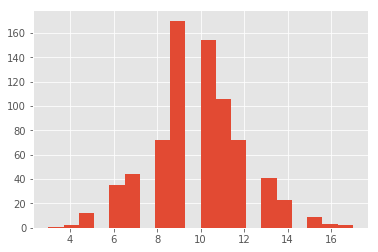

In [24]:
df.ENCODED_RATING.hist(bins=20)

# III - Framework of the problem : Multi Class classification

Each rating is considered as a class and the objective will be to classify correctly each company. However as we see below some classes contain too few elements.

In [70]:
df.groupby('RATING').ENCODED_RATING.count()

RATING
A        72
A+       41
A-      106
AA        9
AA+       3
AA-      23
AAA       2
B         1
B+        2
BB       35
BB+      44
BB-      12
BBB     170
BBB+    154
BBB-     72
Name: ENCODED_RATING, dtype: int64

In [26]:
df.groupby('ENCODED_RATING').ENCODED_RATING.count()/df.shape[0]

ENCODED_RATING
3.0     0.001340
4.0     0.002681
5.0     0.016086
6.0     0.046917
7.0     0.058981
8.0     0.096515
9.0     0.227882
10.0    0.206434
11.0    0.142091
12.0    0.096515
13.0    0.054960
14.0    0.030831
15.0    0.012064
16.0    0.004021
17.0    0.002681
Name: ENCODED_RATING, dtype: float64

Some ratings have too few components. That's why we regoup some classes in order to have more at than 10 elements per class. Indeed if we split between train and test, we need at least few elements for the test class which has 1/3 elements of the total number.

For this reason, we create a new class denominated 'new_rating' which aggregates the less populated classes.

In [27]:
df['new_rating']=df.ENCODED_RATING-5
df.loc[df.ENCODED_RATING<=5,'new_rating']=0
df.loc[df.ENCODED_RATING>=15,'new_rating']=10

In [28]:
new_class_names = ['<BB', 'BB', 'BB+', 'BBB-', 'BBB', 'BBB+', 'A-', 'A', 'A+', 'AA-', '>=AA']

In [29]:
df.groupby('new_rating').new_rating.count()

new_rating
0.0      15
1.0      35
2.0      44
3.0      72
4.0     170
5.0     154
6.0     106
7.0      72
8.0      41
9.0      23
10.0     14
Name: new_rating, dtype: int64

In [30]:
df.groupby('new_rating').new_rating.count()/df.shape[0]

new_rating
0.0     0.020107
1.0     0.046917
2.0     0.058981
3.0     0.096515
4.0     0.227882
5.0     0.206434
6.0     0.142091
7.0     0.096515
8.0     0.054960
9.0     0.030831
10.0    0.018767
Name: new_rating, dtype: float64

## classes are unbalanced

When we plot the histogram of the newly created ratings, we remark that classes are unbalanced. The most represented class has 20% of elements while less populated have 2%.

D:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


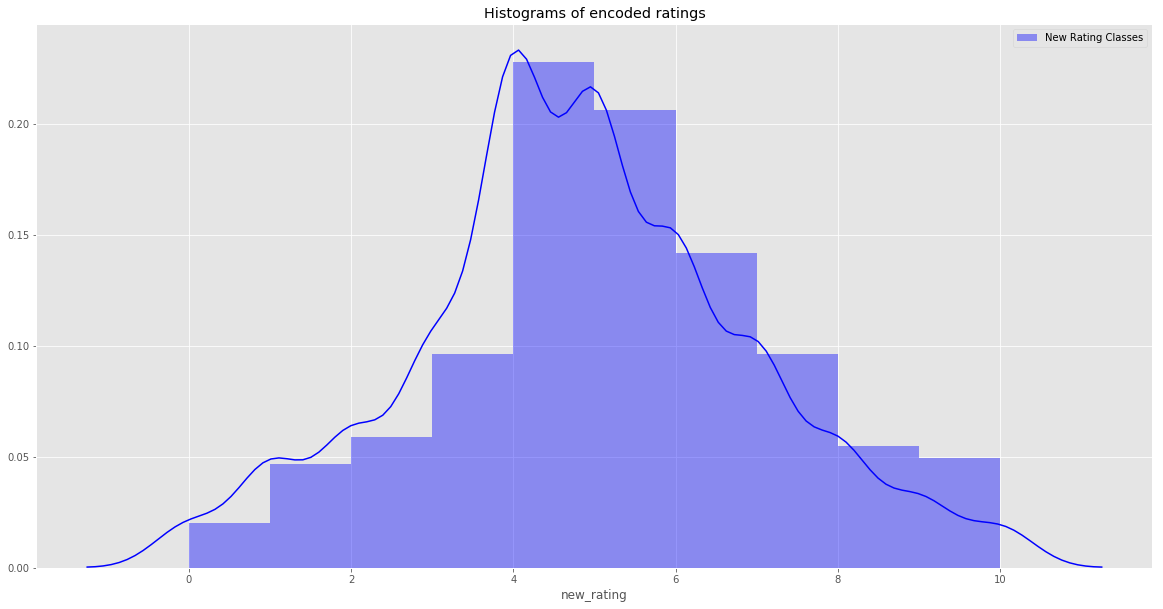

In [31]:
f, ax = plt.subplots(1, 1, figsize=(20,10))
sns.distplot(df.new_rating,color="blue", label="New Rating Classes", ax=ax, bins=range(11))
ax.set_title('Histograms of encoded ratings')
ax.legend()
f.savefig('data/unablanced_classes.png')


We are interested in the quality of the prediction equally on the different classes even though some are more represented. 
The quality on each class can be measured by the F1 score which is a geometric average of :
- precision: reliability of the learner when it makes predictions
- recall: capacity of the learner to detect the classes

This F1 score is computed for each class and then averaged without taking into account the weight of each class.


In [32]:
f1_scorer=make_scorer(sk_metrics.f1_score, average='macro')

# IV -  Machine Learning

## A Introduction

We will compare the perfomance of different machine learning methods to achieve a good classification. The different methods below will be all have hyperparameters optimized with respect to the F1 metric described above. Furtheremore we will add more metrics to have a critical assessement :
- overall accuracy
- average recall
- average precision
- average F1 score

## B Preprocessing

Prepocessing consists of these several steps
- spllitting data beween  train and test sets
  - two variants are done: one for label encoded data and one for one hot encoding
- imputing methods to fill in the nas with median (numerical features) or majority data (categorical data)


In [33]:
X=df[numerical_features+one_hot_categorical_features]
y=pd.to_numeric(df.new_rating, downcast='integer')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=100, stratify=y)

In [34]:
X_label=df[numerical_features+label_categorical_features]
y=pd.to_numeric(df.new_rating, downcast='integer')
X_train_label, X_test_label, y_train_label, y_test_label = train_test_split(X_label, y, test_size=0.33, random_state=100, stratify=y)

In [35]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer= Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', missing_values=np.nan))
])

preprocessor = ColumnTransformer( transformers=[
    ('num', numeric_transformer, numerical_features),
    ('cat', categorical_transformer, one_hot_categorical_features)
])

preprocessor_label = ColumnTransformer( transformers=[
    ('num', numeric_transformer, numerical_features),
    ('cat', categorical_transformer, label_categorical_features)
])

## C Base Estimator : Logistic Regression

In [36]:
base_estimator = Pipeline(steps=[
                           ('preprocessor', preprocessor),
                           ('classifier', LogisticRegression(solver='saga',penalty='l1',C=1, multi_class='multinomial', max_iter=10000, tol=1e-4,n_jobs=-1, random_state=42))
                     ])
base_estimator.fit(X_train, y_train);

In [37]:
logit_scores = get_quality_scores(base_estimator,'Logistic Regression', X_train, X_test,y_train, y_test)
logit_scores

,Logistic Regression
Train Accuracy,55.51%
Train Average Recall,56.05%
Train Average Precision,65.83%
Train Average F1 Score,60.04%
Test Accuracy,21.86%
Test Average Recall,22.72%
Test Average Precision,21.76%
Test Average F1 Score,21.75%


plot_confusion_matrix(base_estimator, X_test, y_test, title='Base Model Confusion Matrix', class_names=new_class_names);

f, ax = plt.subplots(1, 1, figsize=(20,10))
sns.distplot(base_estimator.predict(X_test),color="pink", label="Prediction",ax=ax, bins=range(y_test.min(), y_test.max()+1))
sns.distplot(y_test,color="palegreen", label="Test Set", ax=ax, bins=range(y_test.min(), y_test.max()+1))
ax.set_title('Histograms of encoded ratings')
ax.legend()

## Base Model Cross Validated Hyperparameters

In [38]:
base_estimator.get_params().keys()

dict_keys(['memory', 'steps', 'preprocessor', 'classifier', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__num', 'preprocessor__cat', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__imputer', 'preprocessor__num__scaler', 'preprocessor__num__imputer__copy', 'preprocessor__num__imputer__fill_value', 'preprocessor__num__imputer__missing_values', 'preprocessor__num__imputer__strategy', 'preprocessor__num__imputer__verbose', 'preprocessor__num__scaler__copy', 'preprocessor__num__scaler__with_mean', 'preprocessor__num__scaler__with_std', 'preprocessor__cat__memory', 'preprocessor__cat__steps', 'preprocessor__cat__imputer', 'preprocessor__cat__imputer__copy', 'preprocessor__cat__imputer__fill_value', 'preprocessor__cat__imputer__missing_values', 'preprocessor__cat__imputer__strategy', 'preprocessor__cat__imputer__verbose', 'classifier__C', 'class

In [39]:
params={#'classifier__penalty': ['elasticnet'],
        #'classifier__l1_ratio': [0, 0.25, 0.5, 0.75, 1],           # when 0 it is equivalent to have L2 penalty, when 1 equivalent to L1 penalty, otherwise mix
        'classifier__C': [1e-4,1e-3,1e-2,1e-1,1,1e1,1e2,1e3,1e4],  # Inverse of regularization
        'classifier__class_weight':[None, 'balanced']              # balanced mode adjusts weights inversely proportional to class frequencies
       }
f1_scorer = make_scorer(sk_metrics.f1_score, average='macro')
logit_cv  = GridSearchCV(base_estimator,params,cv=3, scoring = f1_scorer,n_jobs=-1)
logit_cv.fit(X_train,y_train)

D:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbo..., penalty='l1', random_state=42, solver='saga',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10.0, 100.0, 1000.0, 10000.0], 'classifier__class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(f1_score, average=macro), verbose=0)

In [40]:
logit_cv.best_params_

{'classifier__C': 1, 'classifier__class_weight': 'balanced'}

In [41]:
get_quality_scores(logit_cv,'Logistic Regression CV', X_train, X_test,y_train, y_test)

,Logistic Regression CV
Train Accuracy,52.30%
Train Average Recall,69.26%
Train Average Precision,54.86%
Train Average F1 Score,59.42%
Test Accuracy,21.05%
Test Average Recall,27.19%
Test Average Precision,21.71%
Test Average F1 Score,22.26%


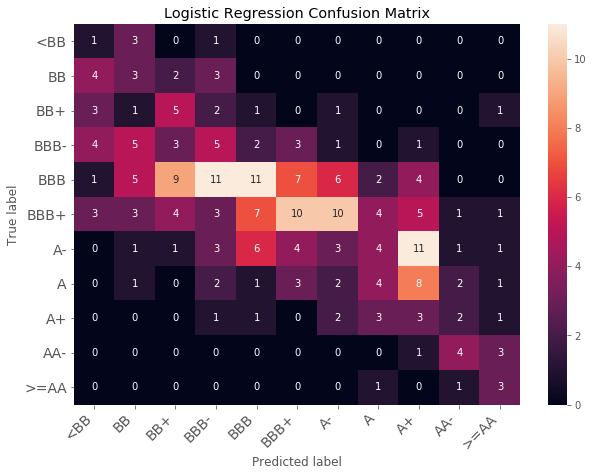

In [42]:
fig_cm_logit = plot_confusion_matrix(logit_cv, X_test, y_test, title='Logistic Regression Confusion Matrix', class_names=new_class_names);
fig_cm_logit.savefig('data/logit_confusion_matrix')

## D: Support Vector Classifier

In [43]:
sv_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SVC())
                     ])
sv_model.fit(X_train, y_train);

D:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


sv_scores = get_quality_scores(sv_model,'SVC', X_train, X_test,y_train, y_test)
sv_scores

In [44]:
params_grid = {'classifier__kernel' : ['linear', 'rbf', 'sigmoid'],
               'classifier__C': [0.001, 0.01, 0.1, 1, 10],
               'classifier__gamma' :[0.001, 0.01, 0.1, 1],
               'classifier__class_weight' : [None, 'balanced']
}
sv_learner_cv = GridSearchCV(sv_model, params_grid, cv=3, scoring = f1_scorer, n_jobs=-1)
sv_learner_cv.fit(X_train, y_train);

D:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [45]:
sv_learner_cv.best_params_

{'classifier__C': 1,
 'classifier__class_weight': 'balanced',
 'classifier__gamma': 0.001,
 'classifier__kernel': 'linear'}

In [46]:
sv_cv_scores=get_quality_scores(sv_learner_cv,'SVC_cv', X_train, X_test,y_train, y_test)
sv_cv_scores

,SVC_cv
Train Accuracy,72.14%
Train Average Recall,84.57%
Train Average Precision,77.19%
Train Average F1 Score,80.03%
Test Accuracy,22.67%
Test Average Recall,23.75%
Test Average Precision,24.47%
Test Average F1 Score,23.46%


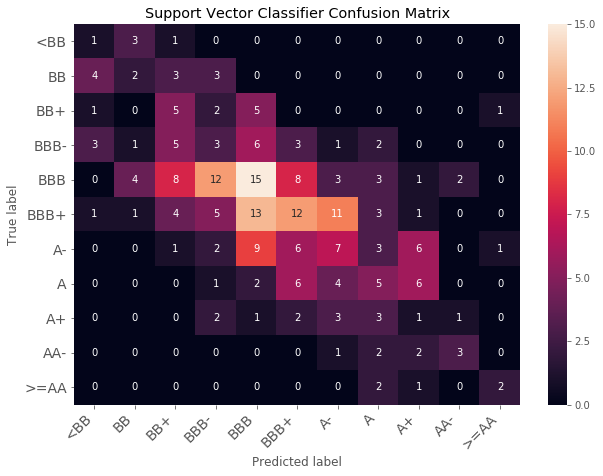

In [47]:
fig_cm_sv = plot_confusion_matrix(sv_learner_cv, X_test, y_test, title='Support Vector Classifier Confusion Matrix', class_names=new_class_names);
fig_cm_sv.savefig('data/sv_confusion_matrix')

## D: Random forest

In [48]:
rf_model = Pipeline(steps=[('preprocessor', preprocessor_label),
                           ('classifier', RandomForestClassifier())
                     ])
rf_model.fit(X_train_label, y_train_label);

D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [49]:
get_quality_scores(rf_model,'Random Forest', X_train_label, X_test_label,y_train_label, y_test_label)

D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Random Forest
Train Accuracy,98.40%
Train Average Recall,97.98%
Train Average Precision,99.06%
Train Average F1 Score,98.50%
Test Accuracy,18.62%
Test Average Recall,12.30%
Test Average Precision,15.05%
Test Average F1 Score,12.41%


In [50]:
rf_model = Pipeline(steps=[('preprocessor', preprocessor_label),
                           ('classifier', RandomForestClassifier())
                     ])
params_grid = {'classifier__n_estimators': [10,100,1000],             # Number of trees in random forest
               'classifier__max_features': ['auto', 'sqrt', 'log2', 3],  # Number of features to consider at every split
               'classifier__max_depth'   : [3,5,20, None],            # Maximum number of levels in tree
               'classifier__min_samples_split' : [2, 5, 10],          # Minimum number of samples required to split a node
               'classifier__min_samples_leaf'   : [1, 2, 4]           # Minimum number of samples required at each leaf node
              }

rf_learner_cv = GridSearchCV(rf_model, params_grid, cv=3, scoring = f1_scorer, n_jobs=-1)
rf_learner_cv.fit(X_train_label, y_train_label);

D:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [51]:
rf_cv_scores = get_quality_scores(rf_learner_cv,'Random Forest CV', X_train_label, X_test_label,y_train_label, y_test_label)
rf_cv_scores

D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Random Forest CV
Train Accuracy,96.79%
Train Average Recall,93.60%
Train Average Precision,97.33%
Train Average F1 Score,95.17%
Test Accuracy,25.51%
Test Average Recall,16.37%
Test Average Precision,16.98%
Test Average F1 Score,16.12%


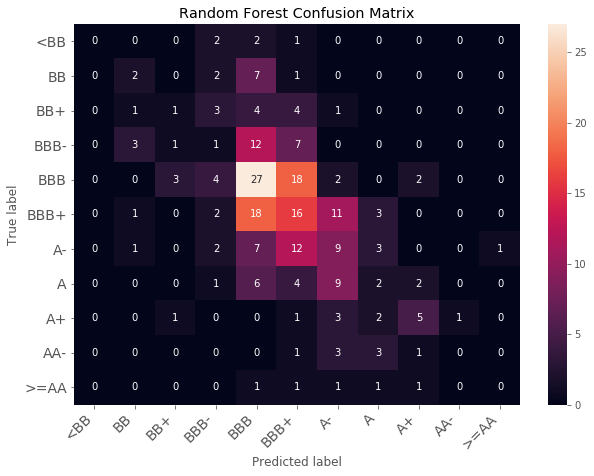

In [52]:
fig_cm_rf = plot_confusion_matrix(rf_learner_cv, X_test_label, y_test_label, title='Random Forest Confusion Matrix', class_names=new_class_names);
fig_cm_rf.savefig('data/rf_confusion_matrix')

## E: Gradient Boosting

In [53]:
gb_model = Pipeline(steps=[('preprocessor', preprocessor_label),
                           ('classifier', GradientBoostingClassifier())
                     ])

params_grid = {'classifier__n_estimators': [10,100,1000],             # Number of trees in random forest
               'classifier__max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider at every split
               'classifier__max_depth'   : [3,5,20, None],            # Maximum number of levels in tree
               'classifier__min_samples_split' : [2, 5, 10],          # Minimum number of samples required to split a node
               'classifier__min_samples_leaf'   : [1, 2, 4]           # Minimum number of samples required at each leaf node
              }

gb_learner_cv = GridSearchCV(gb_model, params_grid, cv=3, scoring = f1_scorer, n_jobs=-1)
gb_learner_cv.fit(X_train_label, y_train_label);

D:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [54]:
gb_cv_scores = get_quality_scores(gb_learner_cv,'Gradient Boosting CV', X_train_label, X_test_label,y_train_label, y_test_label)
gb_cv_scores

,Gradient Boosting CV
Train Accuracy,100.00%
Train Average Recall,100.00%
Train Average Precision,100.00%
Train Average F1 Score,100.00%
Test Accuracy,22.27%
Test Average Recall,15.15%
Test Average Precision,17.09%
Test Average F1 Score,15.55%


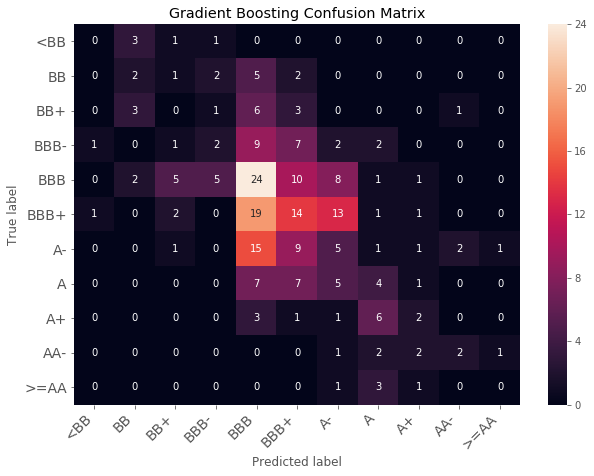

In [55]:
fig_cm_gb = plot_confusion_matrix(gb_learner_cv, X_test_label, y_test_label, title='Gradient Boosting Confusion Matrix', class_names=new_class_names);
fig_cm_gb.savefig('data/gb_confusion_matrix')

# ORDERED CLASSIFICATION MORD

## Mord Logistic AT

In [56]:
mord_at_learner = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('classifier', mord.LogisticAT(alpha=1.))
                     ])
params_grid = {'classifier__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4] }
#my_scorer=make_scorer(sk_metrics.accuracy_score, )
mord_at_cv= GridSearchCV(mord_at_learner, params_grid, cv=3, scoring = f1_scorer, n_jobs=-1)
mord_at_cv.fit(X_train, y_train);

D:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [57]:
mord_at_scores = get_quality_scores(mord_at_cv,'MORD Logistic Regression AT ', X_train, X_test,y_train, y_test)
mord_at_scores

,MORD Logistic Regression AT
Train Accuracy,34.87%
Train Average Recall,26.37%
Train Average Precision,33.29%
Train Average F1 Score,28.34%
Test Accuracy,32.39%
Test Average Recall,26.06%
Test Average Precision,30.62%
Test Average F1 Score,26.24%


In [58]:
#fig, ax =plot_validation_curve(mord_at_learner, X, y,'classifier__alpha', [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],'Validation Curve for Ridge Regression', f1_scorer)

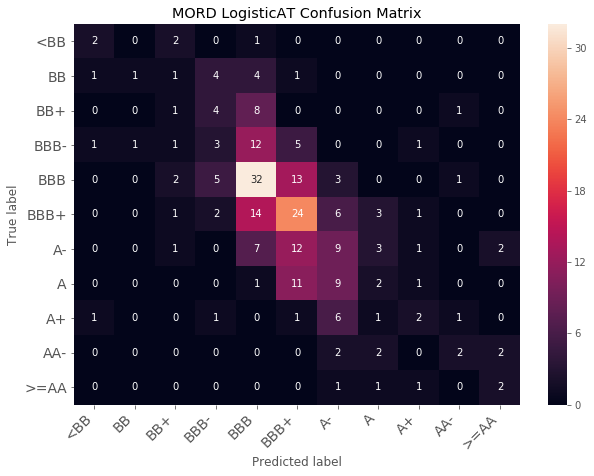

In [59]:
fig_cm_mordat=plot_confusion_matrix(mord_at_cv, X_test, y_test, title='MORD LogisticAT Confusion Matrix', class_names=new_class_names);
fig_cm_mordat.savefig('data/mord_logisticAT_confusion_matrix')

## MORD Logistic IT

In [60]:
mord_it_learner = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('classifier', mord.LogisticIT(alpha=1.))
                     ])
params_grid = {'classifier__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4] }

mord_it_cv = GridSearchCV(mord_it_learner, params_grid, cv=5, scoring = f1_scorer, n_jobs=-1)
mord_it_cv.fit(X_train, y_train);

In [61]:
mord_it_scores = get_quality_scores(mord_it_cv,'MORD Logistic Regression IT ', X_train, X_test,y_train, y_test)
mord_it_scores

D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,MORD Logistic Regression IT
Train Accuracy,33.07%
Train Average Recall,25.12%
Train Average Precision,27.20%
Train Average F1 Score,24.10%
Test Accuracy,31.58%
Test Average Recall,25.54%
Test Average Precision,23.24%
Test Average F1 Score,23.19%


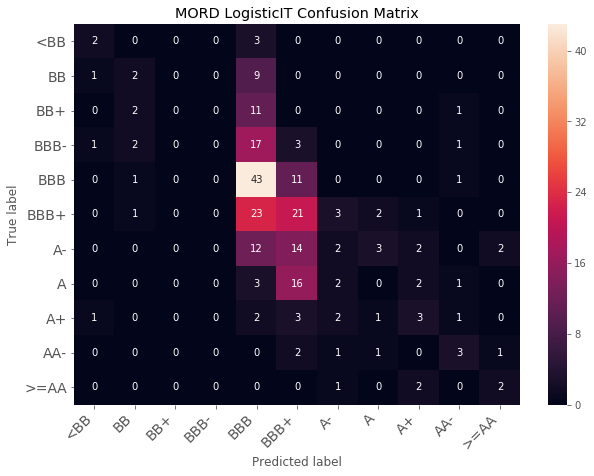

In [62]:
fig_cm_mordit = plot_confusion_matrix(mord_it_cv, X_test, y_test, title='MORD LogisticIT Confusion Matrix', class_names=new_class_names);
fig_cm_mordit.savefig('data/mord_logisticIT_confusion_matrix')

## MORD LAD

In [63]:
mord_lad_learner = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('classifier', mord.LAD(max_iter=10000))
                     ])
params_grid = {'classifier__C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4] }

mord_lad_cv = GridSearchCV(mord_lad_learner, params_grid, cv=5, scoring = f1_scorer, n_jobs=-1)
mord_lad_cv.fit(X_train, y_train);

D:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [64]:
mord_lad_scores = get_quality_scores(mord_lad_cv,'MORD LAD ', X_train, X_test,y_train, y_test)
mord_lad_scores

,MORD LAD
Train Accuracy,35.27%
Train Average Recall,25.48%
Train Average Precision,33.21%
Train Average F1 Score,27.02%
Test Accuracy,28.34%
Test Average Recall,20.90%
Test Average Precision,21.86%
Test Average F1 Score,20.92%


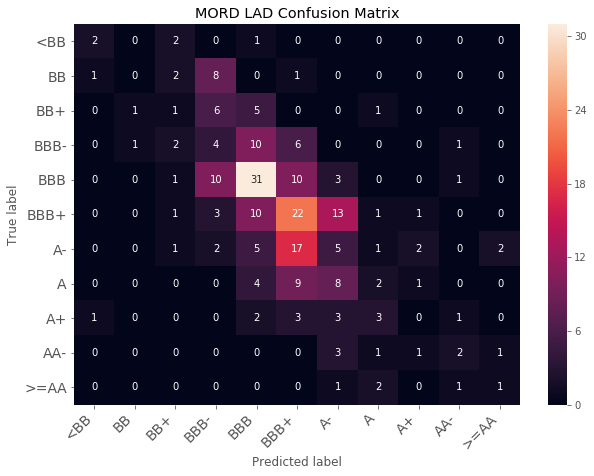

In [65]:
fig_cm_mordLAD = plot_confusion_matrix(mord_lad_cv, X_test, y_test, title='MORD LAD Confusion Matrix', class_names=new_class_names);
fig_cm_mordLAD.savefig('data/mord_LAD_confusion_matrix')

## MORD Ridge Regression

In [66]:
mord_ridge_learner = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('classifier', mord.OrdinalRidge())
                     ])
params_grid = {'classifier__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4] }
mord_ridge_cv = GridSearchCV(mord_ridge_learner, params_grid, cv=5, scoring = f1_scorer, n_jobs=-1)
mord_ridge_cv.fit(X_train, y_train);

In [67]:
mord_ridge_scores = get_quality_scores(mord_ridge_cv,'MORD Ridge ', X_train, X_test,y_train, y_test)
mord_ridge_scores

D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,MORD Ridge
Train Accuracy,32.67%
Train Average Recall,25.65%
Train Average Precision,36.11%
Train Average F1 Score,28.10%
Test Accuracy,29.96%
Test Average Recall,22.44%
Test Average Precision,30.80%
Test Average F1 Score,23.08%


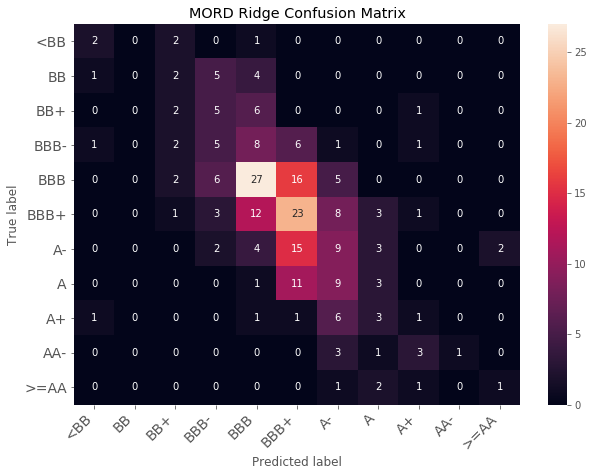

In [68]:
fig_cm_mord_ridge = plot_confusion_matrix(mord_ridge_cv, X_test, y_test, title='MORD Ridge Confusion Matrix', class_names=new_class_names);
fig_cm_mord_ridge.savefig('data/mord_ridge_confusion_matrix')

# Annex

## Logistic Regression with cross validated hyper parameters